In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import fetch_openml, make_moons
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, adjusted_rand_score, confusion_matrix
from sklearn.neighbors import NearestNeighbors

# Plotting settings
plt.rcParams['figure.figsize'] = (10, 6)
sns.set_style('whitegrid')

# Class 3: Clustering

## Introduction: The Challenge of Finding Structure

**Recall from Class 1**: We explored the **curse of dimensionality** - as dimensions increase:
1. **Sparsity**: Data moves to the edges of the space
2. **Distance concentration**: All distances become similar

**Recall from Class 2**: We learned **PCA** as a tool for dimensionality reduction - preserving information while reducing the number of features.

**Today's question**: Can we use these insights to **discover groups** in data?

### What is Clustering?

**Clustering** is the task of grouping similar observations together **without knowing the "correct" groupings beforehand**. This is **unsupervised learning** - we have no labels!

**Key insight**: Clustering relies on **distance-based similarity** (from Class 1):
- **Small distance** = similar observations (should be in same cluster)
- **Large distance** = dissimilar observations (should be in different clusters)

**The curse strikes again!** If distances become meaningless in high dimensions, clustering will fail!

Let's start with a real high-dimensional dataset to see this problem in action.

## The Curse of Dimensionality in Clustering: MNIST

### Real-World Example: Handwritten Digits

**MNIST** is a classic image dataset containing 70,000 handwritten digit images (0-9), each 28×28 pixels.

**From images to numbers**: Each grayscale pixel becomes a feature (0 = white, 255 = black)
- **28 × 28 = 784 features** per image (now we'll handle them as independent features)
- **High-dimensional**: Each image is a point in 784-dimensional space!

**Our goal**: Can K-Means clustering discover the 10 digit classes?

In [2]:
# Load MNIST - the classic handwritten digits dataset
print("Loading MNIST (28x28 images)... this may take a moment on first run...")
mnist = fetch_openml('mnist_784', version=1, as_frame=False, parser='auto')
X_mnist = mnist.data.astype(np.float32)
y_mnist = mnist.target.astype(int)

print(f"\nMNIST Dataset:")
print(f"  Shape: {X_mnist.shape} (samples × pixels)")
print(f"  Classes: {np.unique(y_mnist)} (digits 0-9)")

Loading MNIST (28x28 images)... this may take a moment on first run...

MNIST Dataset:
  Shape: (70000, 784) (samples × pixels)
  Classes: [0 1 2 3 4 5 6 7 8 9] (digits 0-9)


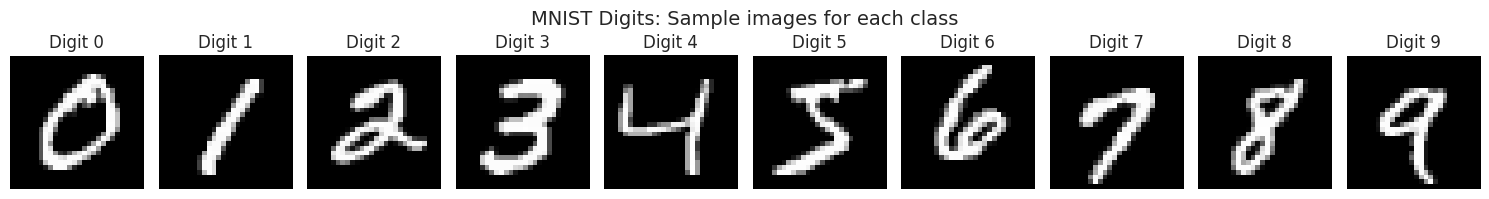

In [3]:
# Visualize some digits
fig, axes = plt.subplots(1, 10, figsize=(15, 2))
fig.suptitle('MNIST Digits: Sample images for each class', fontsize=14)

for i in range(10):
    # Show example digit
    idx = np.where(y_mnist == i)[0][0]
    axes[i].imshow(X_mnist[idx].reshape(28, 28), cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(f'Digit {i}')

plt.tight_layout()
plt.show()

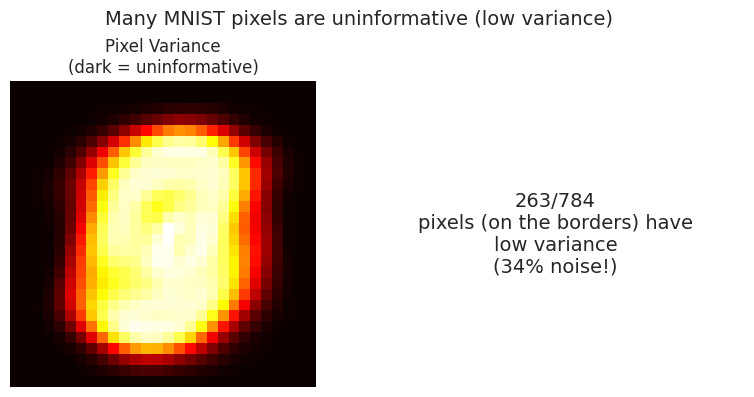

In [4]:
# Identify uninformative pixels: show pixel variance across all images
pixel_variance = X_mnist.var(axis=0)

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
fig.suptitle('Many MNIST pixels are uninformative (low variance)', fontsize=14)

# Show variance heatmap
axes[0].imshow(pixel_variance.reshape(28, 28), cmap='hot')
axes[0].set_title('Pixel Variance\n(dark = uninformative)')
axes[0].axis('off')

# Count uninformative pixels
low_var_threshold = 100  # pixels with variance < 100
n_low_var = (pixel_variance < low_var_threshold).sum()
axes[1].text(0.5, 0.5, f'{n_low_var}/784\npixels (on the borders) have\nlow variance\n({n_low_var/784:.0%} noise!)', 
             ha='center', va='center', fontsize=14, transform=axes[1].transAxes)
axes[1].axis('off')

plt.tight_layout()
plt.show()

Shall we standardize?

### The Curse Manifests: Distance Concentration

**Recall from Class 1**: In high dimensions, the ratio of maximum to minimum distances approaches 1.

Let's verify this happens in MNIST! We'll keep 200 images and look at their pairwise distances with different number of features (pixels).

In [5]:
# Sample images
np.random.seed(20260225)
sample_size = 200
sample_idx = np.random.choice(len(X_mnist), sample_size, replace=False)
X_sample = X_mnist[sample_idx]
X_sample.shape

(200, 784)

Computing pairwise distances for 200 samples...
⏱️  Completed in 0.9 seconds


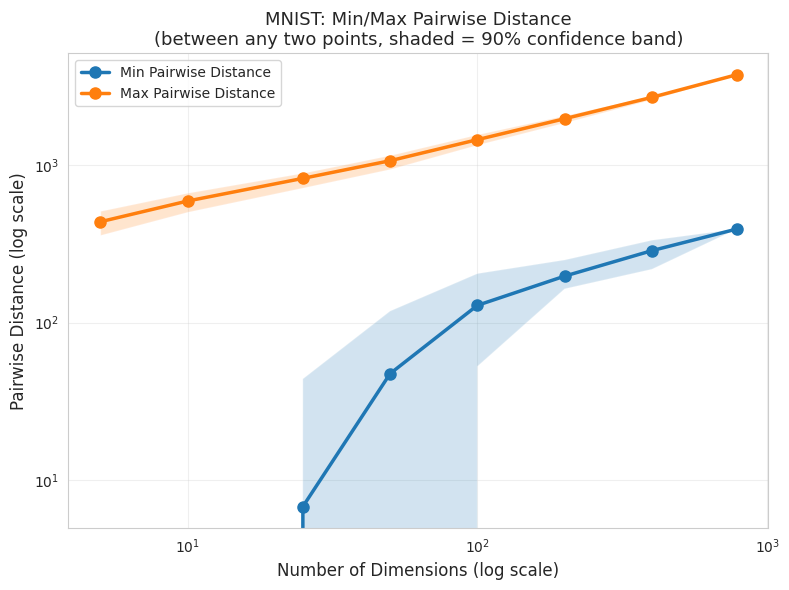

In [6]:
# Pairwise distances
from scipy.spatial.distance import pdist
import time

def run_mnist_pairwise_experiment(X_sample, dimensions, n_bootstrap=200):
    """
    For each dimension count, randomly select that many features from MNIST,
    then compute ALL pairwise distances and find min/max.
    Note: pdist computes n*(n-1)/2 distances, so we use fewer samples.
    """
    np.random.seed(20260225) # reset
    
    results = {'dimensions': dimensions, 
               'min_mean': [], 'min_lower': [], 'min_upper': [],
               'max_mean': [], 'max_lower': [], 'max_upper': []}
    
    for dim in dimensions:
        min_dists = []
        max_dists = []
        
        for boot in range(n_bootstrap):
            # Randomly select 'dim' features (pixels)
            selected_dims = np.random.choice(784, min(dim, 784), replace=False)
            X_subset = X_sample[:, selected_dims]
            
            # Compute ALL pairwise distances
            pairwise_distances = pdist(X_subset, metric='euclidean')

            min_dists.append(np.min(pairwise_distances))
            max_dists.append(np.max(pairwise_distances))
        
        # Calculate mean and 90% confidence intervals
        results['min_mean'].append(np.mean(min_dists))
        results['min_lower'].append(np.percentile(min_dists, 5))
        results['min_upper'].append(np.percentile(min_dists, 95))
        
        results['max_mean'].append(np.mean(max_dists))
        results['max_lower'].append(np.percentile(max_dists, 5))
        results['max_upper'].append(np.percentile(max_dists, 95))
    
    return results

# Run experiment with pairwise distances
dimensions = [5, 10, 25, 50, 100, 200, 400, 784]

print(f"Computing pairwise distances for {sample_size} samples...")
start_time = time.time()

results_pairwise = run_mnist_pairwise_experiment(X_sample, dimensions, n_bootstrap=30)

elapsed = time.time() - start_time
print(f"⏱️  Completed in {elapsed:.1f} seconds")

# Plot the results
fig, ax = plt.subplots(figsize=(8, 6))

dims = results_pairwise['dimensions']

# Min and Max pairwise distances
ax.plot(dims, results_pairwise['min_mean'], 'o-', linewidth=2.5, markersize=8, label='Min Pairwise Distance')
ax.fill_between(dims, results_pairwise['min_lower'], results_pairwise['min_upper'], alpha=0.2)

ax.plot(dims, results_pairwise['max_mean'], 'o-', linewidth=2.5, markersize=8, label='Max Pairwise Distance')
ax.fill_between(dims, results_pairwise['max_lower'], results_pairwise['max_upper'], alpha=0.2)

ax.set_xlabel('Number of Dimensions (log scale)', fontsize=12)
ax.set_ylabel('Pairwise Distance (log scale)', fontsize=12)
ax.set_title('MNIST: Min/Max Pairwise Distance\n(between any two points, shaded = 90% confidence band)', fontsize=13)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_xscale('log')
ax.set_yscale('log')

plt.tight_layout()
plt.show()

### Clustering with KMeans

Now let's apply K-Means clustering to our MNIST data to see how well it can discover the natural groupings (digits 0-9).

**What we're doing:**
1. **Sample 200 images** randomly from the full MNIST dataset
2. **Run K-Means with K=10** clusters (matching the 10 digit classes), using `n_init=10` (10 random initializations to find the best solution) -- with the same `sklearn` pattern we already saw in action: `define` → `fit` → `predict`
3. **Evaluate the clustering** using two approaches:

**Confusion Matrix**: Shows how K-Means clusters align with true digit labels
- Each row = a true digit (0-9)
- Each column = a K-Means cluster (0-9)
- Cell values = count of images with that true label assigned to that cluster
- Ideally, each cluster would contain only one digit → diagonal matrix

**Adjusted Rand Index (ARI)**: A single number measuring clustering quality
- Compares predicted clusters to true labels by counting pairwise agreements:
  - Do two images from the same true class end up in the same cluster?
  - Do two images from different true classes end up in different clusters?
- **ARI = 1**: Perfect clustering (clusters exactly match true groups)
- **ARI = 0**: No better than random chance
- **ARI < 0**: Worse than random (rare)
- Unlike simple accuracy, ARI is **adjusted for chance** — it accounts for the fact that random assignments can appear to agree by coincidence

#### Math detour: ARI

The **Adjusted Rand Index (ARI)** measures agreement between two clusterings, adjusting for chance:

$$\text{ARI} = \frac{\text{RI} - \mathbb{E}[\text{RI}]}{\max(\text{RI}) - \mathbb{E}[\text{RI}]}$$

**The Rand Index (RI)** counts pairwise agreements:

$$\text{RI} = \frac{a + b}{\binom{n}{2}}$$

Where:
- $a$ = pairs of points in the **same** cluster in **both** clusterings (true positives)
- $b$ = pairs of points in **different** clusters in **both** clusterings (true negatives)
- $\binom{n}{2}$ = total number of pairs

**Intuition**: RI asks for each pair of points: "Do the two clusterings agree on whether these points belong together?"

**Why adjust for chance?** With many clusters, random assignments can appear to agree by coincidence. The adjustment corrects for this expected agreement under random label assignment, which is why **ARI = 0 means "no better than random"** rather than "no agreement at all."


In [7]:
prng = np.random.RandomState(20260225)

sample_idx = prng.choice(len(X_mnist), sample_size, replace=False)
X_sample = X_mnist[sample_idx]
y_sample = y_mnist[sample_idx]

kmeans = KMeans(n_clusters=10, random_state=prng, n_init=10)
labels = kmeans.fit_predict(X_sample)

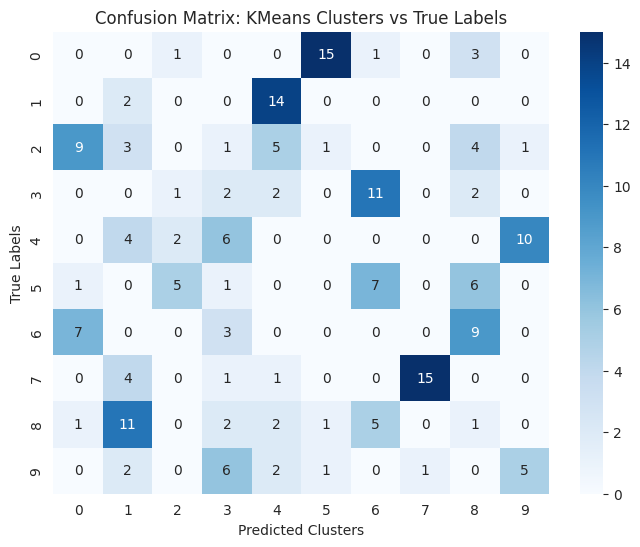

In [8]:
# Create confusion matrix between kmeans labels and true labels
def plot_confusion_matrix(true_y, kmeans_labels):
    conf_matrix = confusion_matrix(true_y, kmeans_labels)

    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title("Confusion Matrix: KMeans Clusters vs True Labels")
    plt.xlabel("Predicted Clusters")
    plt.ylabel("True Labels")

plot_confusion_matrix(y_sample, labels)

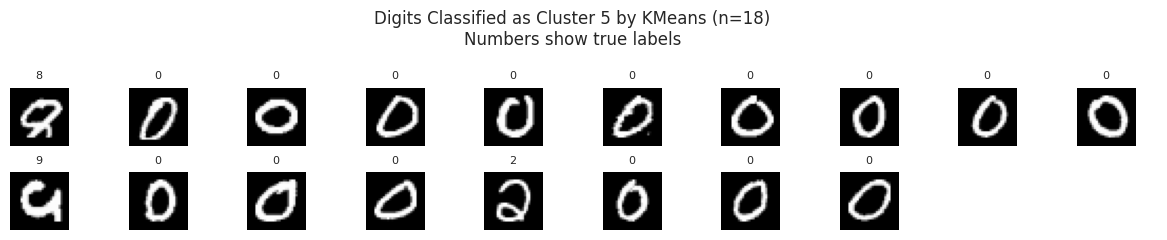

In [9]:
# Plot all digits classified as cluster 5 by KMeans
def plot_cluster(cluster_label):
    cluster_indices = np.where(labels == cluster_label)[0]
    cluster_images = X_sample[cluster_indices]
    cluster_true_labels = y_sample[cluster_indices]

    n_images = len(cluster_indices)
    n_cols = 10
    n_rows = (n_images + n_cols - 1) // n_cols  # Ceiling division

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 1.2 * n_rows))
    axes = axes.flatten()

    for i, ax in enumerate(axes):
        if i < n_images:
            ax.imshow(cluster_images[i].reshape(28, 28), cmap='gray')
            ax.set_title(f'{int(cluster_true_labels[i])}', fontsize=8)
        ax.axis('off')

    plt.suptitle(f'Digits Classified as Cluster {cluster_label} by KMeans (n={n_images})\nNumbers show true labels', fontsize=12)
    plt.tight_layout()
    plt.show()

plot_cluster(cluster_label=5)

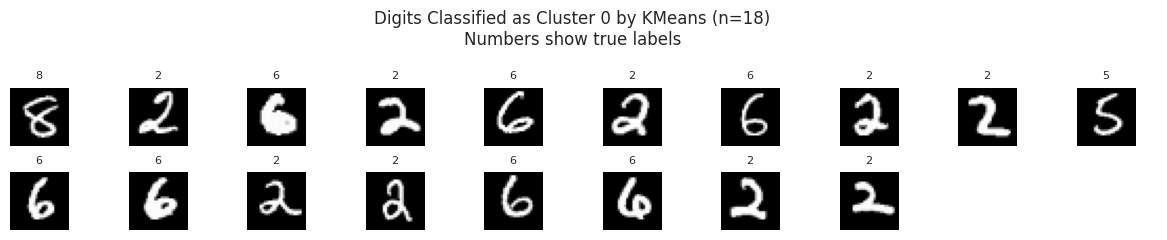

In [10]:

plot_cluster(0)

In [11]:
# Express goodness of fit with ARI: adjusted rand index

ari = adjusted_rand_score(y_sample, labels)
print(f"Adjusted Rand Index (ARI): {ari:.3f}")

Adjusted Rand Index (ARI): 0.276


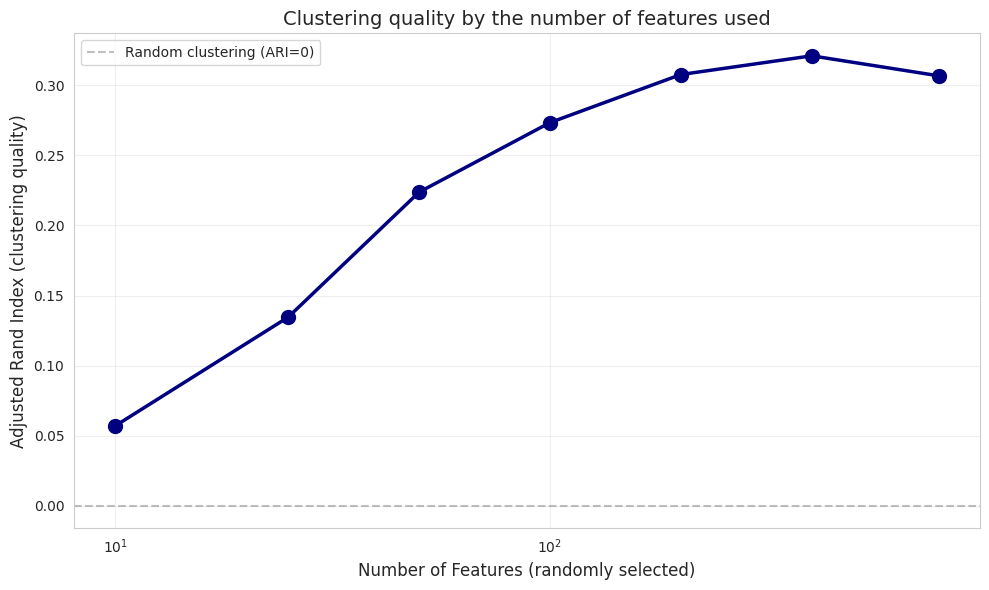

In [13]:
# Let's see how K-Means performs with only 200 samples across different numbers of features

prng = np.random.RandomState(20260226) # reset random state for reproducibility

# Recreate sample
sample_idx = prng.choice(len(X_mnist), sample_size, replace=False)
X_sample = X_mnist[sample_idx]
y_sample = y_mnist[sample_idx]

# Test clustering quality across different numbers of randomly selected features
feature_counts = [10, 25, 50, 100, 200, 400, 784]
ari_scores = []

for n_features in feature_counts:
    # Randomly select features (simulating different dimensionalities)
    selected_features = prng.choice(784, n_features, replace=False)
    X_subset = X_sample[:, selected_features]
    
    # K-Means clustering
    kmeans = KMeans(n_clusters=10, random_state=prng, n_init=10)
    labels = kmeans.fit_predict(X_subset)
    
    # Measure quality
    ari = adjusted_rand_score(y_sample, labels)
    ari_scores.append(ari)

# Visualize
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(feature_counts, ari_scores, 'o-', linewidth=2.5, markersize=10, color='navy')
ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5, label='Random clustering (ARI=0)')

ax.set_xlabel('Number of Features (randomly selected)', fontsize=12)
ax.set_ylabel('Adjusted Rand Index (clustering quality)', fontsize=12)
ax.set_title(f'Clustering quality by the number of features used', fontsize=14)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_xscale('log')

plt.tight_layout()
plt.show()

## Can PCA Help? Combating the Curse

**Recall from Class 2**: PCA finds directions of maximum variance.

**Key insight**: In MNIST, PCA automatically focuses on **informative pixels** (digit center) and ignores **uninformative pixels** (borders). By reducing dimensions, we:

1. **Filter out noise**: Low-variance dimensions are discarded
2. **Concentrate signal**: Remaining dimensions contain the useful information
3. **Make distances meaningful again**: Distances now reflect actual digit similarity

Let's see if PCA helps our clustering!

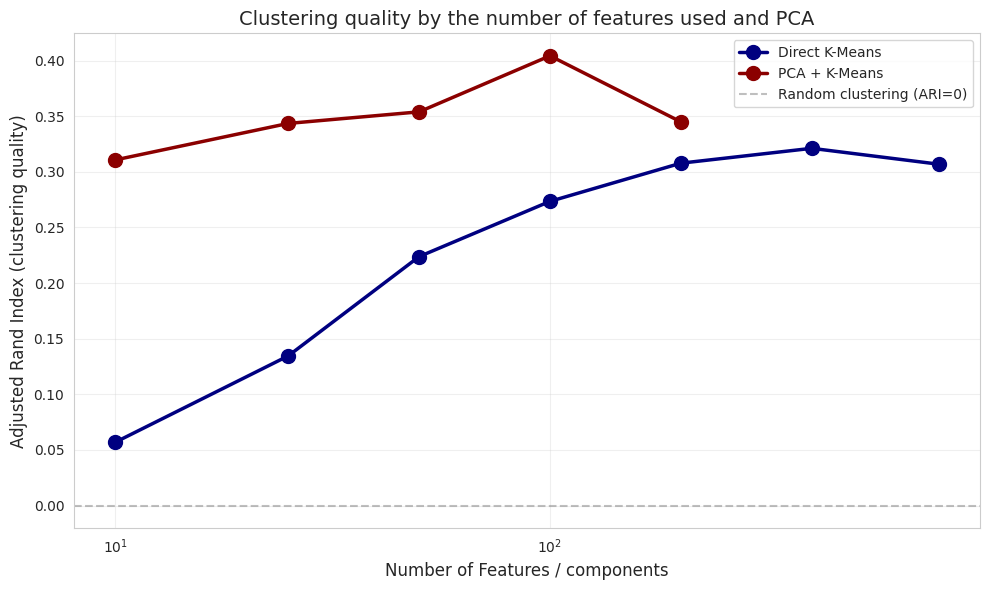

In [14]:
# Compare: Direct K-Means vs PCA + K-Means

prng = np.random.RandomState(20260225) # reset random state for reproducibility

# Recreate sample
sample_idx = prng.choice(len(X_mnist), sample_size, replace=False)
X_sample = X_mnist[sample_idx]
y_sample = y_mnist[sample_idx]

component_counts = [10, 25, 50, 100, 200]

ari_scores_pca = []

for n_component in component_counts:
    pca = PCA(n_components=n_component, random_state=prng) # the standard optimizer uses randomization
    X_pca = pca.fit_transform(X_sample)
    kmeans_pca = KMeans(n_clusters=10, random_state=prng, n_init=10)
    labels_pca = kmeans_pca.fit_predict(X_pca)
    ari_pca = adjusted_rand_score(y_sample, labels_pca)
    
    ari_scores_pca.append(ari_pca)

# Visualize
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(feature_counts, ari_scores, 'o-', linewidth=2.5, markersize=10, color='navy', label='Direct K-Means')
ax.plot(component_counts, ari_scores_pca, 'o-', linewidth=2.5, markersize=10, color='darkred', label='PCA + K-Means')
ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5, label='Random clustering (ARI=0)')

ax.set_xlabel('Number of Features / components', fontsize=12)
ax.set_ylabel('Adjusted Rand Index (clustering quality)', fontsize=12)
ax.set_title(f'Clustering quality by the number of features used and PCA', fontsize=14)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_xscale('log')

plt.tight_layout()
plt.show()

In [15]:
PCA(n_components=100).fit(X_sample).explained_variance_ratio_.sum()

np.float32(0.9668775)

---

**We've seen the problem**: High dimensions hurt clustering, especially with limited data. PCA can help by filtering noise.

**But how does K-Means actually work?** Before we apply it to real-world problems, let's understand the algorithm itself.

## K-Means Algorithm: How Does It Work?

Now that we've seen PCA helps clustering, let's understand **how K-Means actually works**.

### The Intuition

**K-Means** is one of the most popular clustering algorithms. It works through a simple iterative process:

1. **Choose K** (the number of clusters you want to find)
2. **Initialize**: Randomly place K "cluster centers" (centroids)
3. **Repeat** until convergence:
   - **Assignment step**: Assign each observation to the nearest centroid
   - **Update step**: Move each centroid to the average position of its assigned observations

**Goal**: Minimize the total distance between observations and their assigned centroids

**Visual explanation**: [StatQuest video on K-Means](https://www.youtube.com/watch?v=4b5d3muPQmA)

#### Math Detour: K-Means Objective Function

K-Means minimizes the **within-cluster sum of squares (WCSS)**, also called **inertia**:

$$\text{WCSS} = \sum_{k=1}^{K} \sum_{x_i \in C_k} \|x_i - \mu_k\|^2$$

Where:
- $K$ = number of clusters
- $C_k$ = set of observations in cluster $k$
- $\mu_k$ = centroid (mean) of cluster $k$
- $\|x_i - \mu_k\|^2$ = squared Euclidean distance

**Intuition**: Sum up all squared distances from each point to its assigned cluster center. Smaller is better!

**Assignment step**: For each observation $x_i$, assign to cluster $k$ that minimizes $\|x_i - \mu_k\|$

**Update step**: For each cluster $k$, update centroid as the mean: $\mu_k = \frac{1}{|C_k|} \sum_{x_i \in C_k} x_i$

These two steps alternate until centroids stop moving (convergence).

### Choosing K: How Many Clusters?

**Problem**: In real data, we usually don't know the true number of clusters!

For MNIST we know K=10 (digits 0-9), but what if we didn't?

**Solution**: Use the **Elbow Method** with inertia

**Inertia** = Total squared distance from observations to their assigned centroids
- **Lower is better** (observations closer to centroids)
- But inertia always decreases as K increases!
- Look for the "elbow" - where improvement slows down

**Other metrics exist** (like Silhouette Score), but the elbow method is simple and usually sufficient. Use alternative metrics when the elbow is unclear. (Note that ARI only works if we know the true labels.)

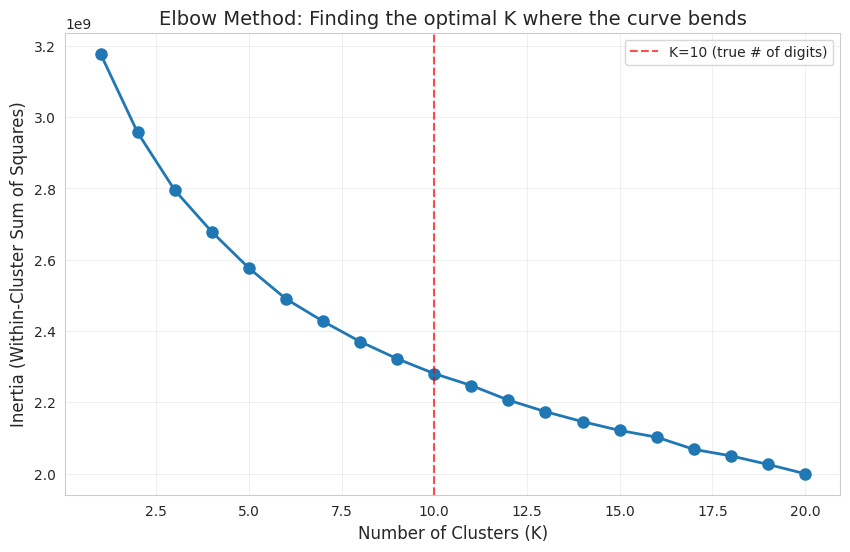

In [16]:
prng = np.random.RandomState(20260225) # reset random state for reproducibility

# Recreate a larger sample
sample_size = 1000
sample_idx = prng.choice(len(X_mnist), sample_size, replace=False)
X_sample = X_mnist[sample_idx]
y_sample = y_mnist[sample_idx]

pca = PCA(n_components=100, random_state=prng)
X_pca = pca.fit_transform(X_sample)

# Calculate inertia for K = 1 to 20
K_range = range(1, 21)
inertias = []

for k in K_range:
    kmeans_temp = KMeans(n_clusters=k, random_state=prng, n_init=10)
    kmeans_temp.fit(X_pca)
    inertias.append(kmeans_temp.inertia_)

# Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(K_range, inertias, marker='o', linewidth=2, markersize=8)
plt.axvline(x=10, color='red', linestyle='--', alpha=0.7, label='K=10 (true # of digits)')
plt.xlabel('Number of Clusters (K)', fontsize=12)
plt.ylabel('Inertia (Within-Cluster Sum of Squares)', fontsize=12)
plt.title('Elbow Method: Finding the optimal K where the curve bends', fontsize=14)
plt.legend()
plt.grid(alpha=0.3)
plt.show()


### Why Not Use Supervised Learning?

You might be thinking: **"We have digit labels! Why not just train a classifier?"**

Great question! In MNIST, we used labels only to **evaluate** clustering quality (via ARI). But in practice:

**Supervised learning requires labels** → Expensive/impossible to obtain:
- Medical diagnosis: Expert radiologists must label thousands of images
- Customer segmentation: No "correct" groupings exist a priori
- Anomaly detection: Anomalies are rare and unlabeled
- Gene expression: Biological pathways aren't fully known

**Clustering is for discovery** → Find structure you didn't know existed:
- What customer segments naturally exist?
- Are there distinct subtypes of this disease?
- Which countries form natural economic groupings?

### Real-World Example: Country Segmentation

In Class 2, we used PCA to understand economic indicators across countries. Now let's ask:

**Can K-Means discover meaningful country groupings?**

In [17]:
# Load the World Bank economic indicators data (same as Class 2)
df_countries = pd.read_csv('../data/economic_indicators/countries_wb_2020_2023.csv')

# Define features for clustering (same 9 indicators from PCA class)
feature_cols = ['GDP_per_capita', 'Inflation_rate', 'Unemployment_rate', 
                'Trade_percent_GDP', 'Health_spending_pct_GDP', 'Life_expectancy',
                'Internet_users_pct', 'RD_spending_pct_GDP', 'FDI_pct_GDP']

# Extract features
X_countries = df_countries[feature_cols].copy()

print(f"Countries: {len(df_countries)}")
print(f"Features: {len(feature_cols)}")
print(f"\nFeatures: {feature_cols}")

Countries: 70
Features: 9

Features: ['GDP_per_capita', 'Inflation_rate', 'Unemployment_rate', 'Trade_percent_GDP', 'Health_spending_pct_GDP', 'Life_expectancy', 'Internet_users_pct', 'RD_spending_pct_GDP', 'FDI_pct_GDP']


**Recall from Class 2**: Features have vastly different scales (GDP in tens of thousands vs. percentages). We must **standardize** before clustering, just like we did for PCA!

In [18]:
# Standardize features (critical for distance-based clustering!)
scaler_countries = StandardScaler()
X_countries_scaled = scaler_countries.fit_transform(X_countries)

print("After standardization:")
print(f"Means (should be ~0): {X_countries_scaled.mean(axis=0).round(2)}")
print(f"Std devs (should be ~1): {X_countries_scaled.std(axis=0).round(2)}")

After standardization:
Means (should be ~0): [ 0. -0.  0.  0.  0.  0.  0.  0.  0.]
Std devs (should be ~1): [1. 1. 1. 1. 1. 1. 1. 1. 1.]


### Optional Exercise

Experiment with various numbers of clusters, whether to apply PCA or not, etc., and see what you can learn from the data. Unsupervised learning can be part of exploratory data analysis.


## When K-Means Fails: Non-Spherical Clusters

K-Means has a fundamental assumption: **clusters are spherical** (round in all dimensions).

**What if our data has different shapes?**

Let's look at a challenging dataset where K-Means will fail:

/tmp/ipykernel_11815/3554501694.py:25: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/balintdecsi/repos/ceu/ceu-ml/.venv/lib/python3.14/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


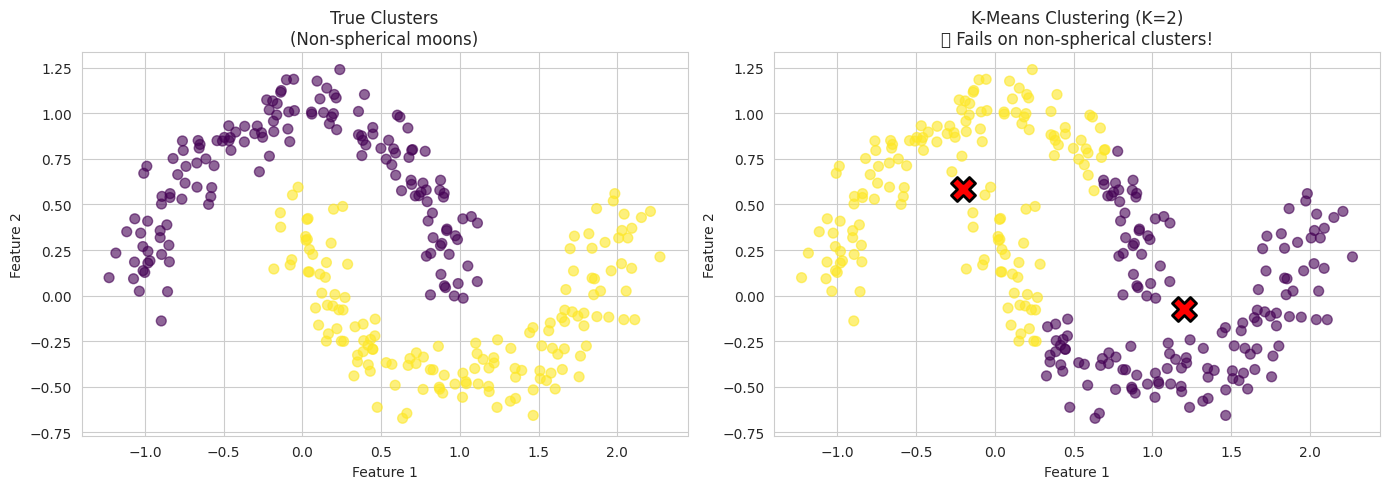

K-Means ARI: 0.254


In [19]:
# Generate moon-shaped clusters
X_moons, y_moons = make_moons(n_samples=300, noise=0.1, random_state=42)

# Try K-Means on this data
kmeans_moons = KMeans(n_clusters=2, random_state=42, n_init=10)
kmeans_labels_moons = kmeans_moons.fit_predict(X_moons)

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: True structure
axes[0].scatter(X_moons[:, 0], X_moons[:, 1], c=y_moons, cmap='viridis', alpha=0.6, s=50)
axes[0].set_title('True Clusters\n(Non-spherical moons)', fontsize=12)
axes[0].set_xlabel('Feature 1')
axes[0].set_ylabel('Feature 2')

# Right: K-Means result
axes[1].scatter(X_moons[:, 0], X_moons[:, 1], c=kmeans_labels_moons, cmap='viridis', alpha=0.6, s=50)
axes[1].scatter(kmeans_moons.cluster_centers_[:, 0], kmeans_moons.cluster_centers_[:, 1],
                c='red', marker='X', s=300, edgecolors='black', linewidth=2)
axes[1].set_title('K-Means Clustering (K=2)\n❌ Fails on non-spherical clusters!', fontsize=12)
axes[1].set_xlabel('Feature 1')
axes[1].set_ylabel('Feature 2')

plt.tight_layout()
plt.show()

ari_kmeans = adjusted_rand_score(y_moons, kmeans_labels_moons)
print(f"K-Means ARI: {ari_kmeans:.3f}")

### DBSCAN: Density-Based Clustering

**Solution**: Use density-based clustering!

**DBSCAN** (Density-Based Spatial Clustering of Applications with Noise) identifies clusters based on **density**, not distance to centroids.

**Core idea**: Clusters are dense regions separated by sparse regions

DBSCAN identifies:
1. **Core points**: Points with many neighbors within radius ε (epsilon)
2. **Border points**: Points within ε of a core point (but not core themselves)
3. **Noise points**: Points that are neither core nor border (outliers!)

**Key parameters**:
- **`eps` (ε)**: Maximum distance between two points to be neighbors
- **`min_samples`**: Minimum number of neighbors to be a core point

**Advantages over K-Means**:
- Can find clusters of **arbitrary shape**
- Automatically identifies **outliers**
- **Don't need to specify number of clusters!**

**Visual explanation**: [StatQuest video on DBSCAN](https://www.youtube.com/watch?v=RDZUdRSDOok)

#### Math Detour: DBSCAN Formal Definition

DBSCAN uses two parameters to define density:
- **ε (epsilon)**: Neighborhood radius
- **MinPts**: Minimum points required to form a dense region

**Definitions**:

1. **ε-neighborhood** of point $p$: $N_\varepsilon(p) = \{q \in D \mid \text{dist}(p,q) \leq \varepsilon\}$
   - All points within distance ε from point p

2. **Core point**: A point $p$ is a core point if $|N_\varepsilon(p)| \geq \text{MinPts}$
   - Has at least MinPts neighbors (including itself) within radius ε

3. **Directly density-reachable**: Point $q$ is directly density-reachable from $p$ if:
   - $p$ is a core point, AND
   - $q \in N_\varepsilon(p)$

4. **Density-reachable**: Point $q$ is density-reachable from $p$ if there's a chain of directly density-reachable points connecting them

5. **Density-connected**: Points $p$ and $q$ are density-connected if both are density-reachable from some core point $o$

**Cluster formation**: A cluster is a maximal set of density-connected points. Points that aren't density-reachable from any core point are labeled as **noise** (-1).


In [20]:
# Apply DBSCAN to moon data
dbscan = DBSCAN(eps=0.2, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_moons)

# Count results
n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_outliers = np.sum(dbscan_labels == -1)

print(f"Number of clusters found: {n_clusters}")
print(f"Number of outliers: {n_outliers}")

ari_dbscan = adjusted_rand_score(y_moons, dbscan_labels)
print(f"DBSCAN ARI: {ari_dbscan:.3f}")

Number of clusters found: 2
Number of outliers: 0
DBSCAN ARI: 1.000


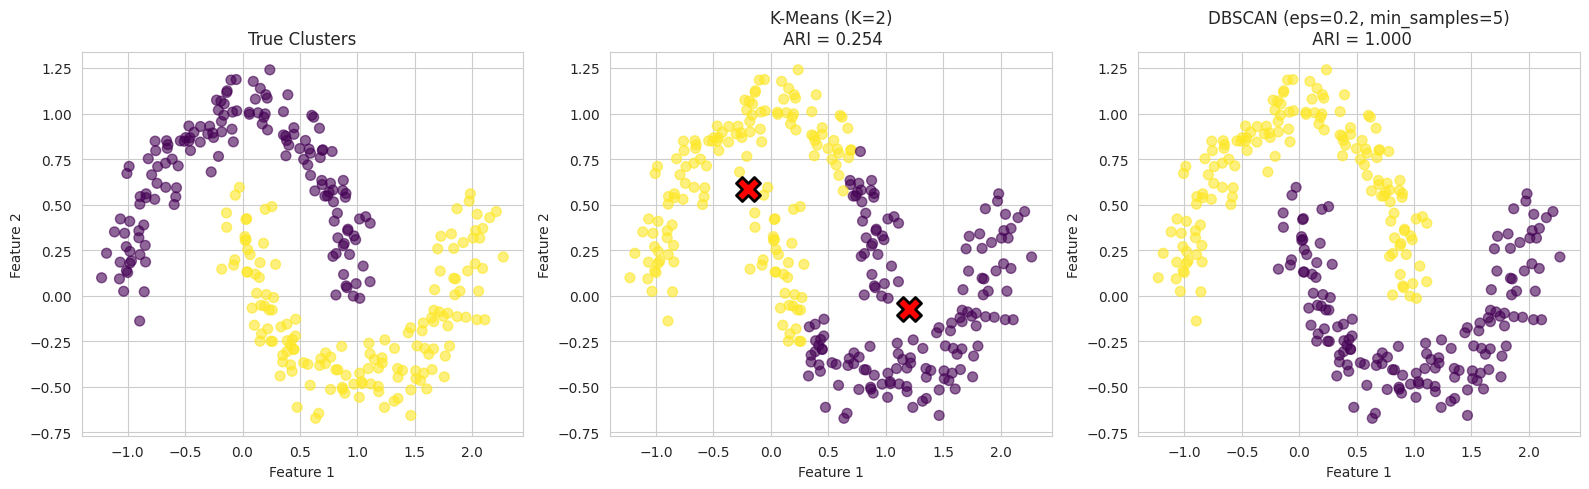


🎯 DBSCAN successfully finds the crescent-shaped clusters!
   It works by connecting dense regions, not finding centroids.


In [21]:
# Visualize comparison: K-Means vs DBSCAN
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Left: True clusters
axes[0].scatter(X_moons[:, 0], X_moons[:, 1], c=y_moons, cmap='viridis', alpha=0.6, s=50)
axes[0].set_title('True Clusters', fontsize=12)
axes[0].set_xlabel('Feature 1')
axes[0].set_ylabel('Feature 2')

# Middle: K-Means (failed)
axes[1].scatter(X_moons[:, 0], X_moons[:, 1], c=kmeans_labels_moons, cmap='viridis', alpha=0.6, s=50)
axes[1].scatter(kmeans_moons.cluster_centers_[:, 0], kmeans_moons.cluster_centers_[:, 1],
                c='red', marker='X', s=300, edgecolors='black', linewidth=2)
axes[1].set_title(f'K-Means (K=2)\n ARI = {ari_kmeans:.3f}', fontsize=12)
axes[1].set_xlabel('Feature 1')
axes[1].set_ylabel('Feature 2')

# Right: DBSCAN (success!)
# Plot clusters
mask_clustered = dbscan_labels != -1
axes[2].scatter(X_moons[mask_clustered, 0], X_moons[mask_clustered, 1], 
                c=dbscan_labels[mask_clustered], cmap='viridis', alpha=0.6, s=50)
# Plot outliers in black
if n_outliers > 0:
    mask_outliers = dbscan_labels == -1
    axes[2].scatter(X_moons[mask_outliers, 0], X_moons[mask_outliers, 1],
                    c='black', marker='x', s=100, alpha=0.5, label='Outliers')
    axes[2].legend()
axes[2].set_title(f'DBSCAN (eps={dbscan.eps}, min_samples={dbscan.min_samples})\n ARI = {ari_dbscan:.3f}', fontsize=12)
axes[2].set_xlabel('Feature 1')
axes[2].set_ylabel('Feature 2')

plt.tight_layout()
plt.show()

print("\n🎯 DBSCAN successfully finds the crescent-shaped clusters!")
print("   It works by connecting dense regions, not finding centroids.")

### Choosing DBSCAN Parameters

**Challenge**: How to choose `eps` and `min_samples`?

**Rules of thumb**:
- **`min_samples`**: 
  - Start with 2 × dimensions + 1 (e.g., 5 for 2D data)
  - Larger values = fewer, denser clusters
- **`eps`**: 
  - Look at k-distance graph (distance to k-th nearest neighbor)
  - Choose eps at the "elbow" of this graph
  - Or use domain knowledge about meaningful distance

Let's see how different `eps` values affect the results:

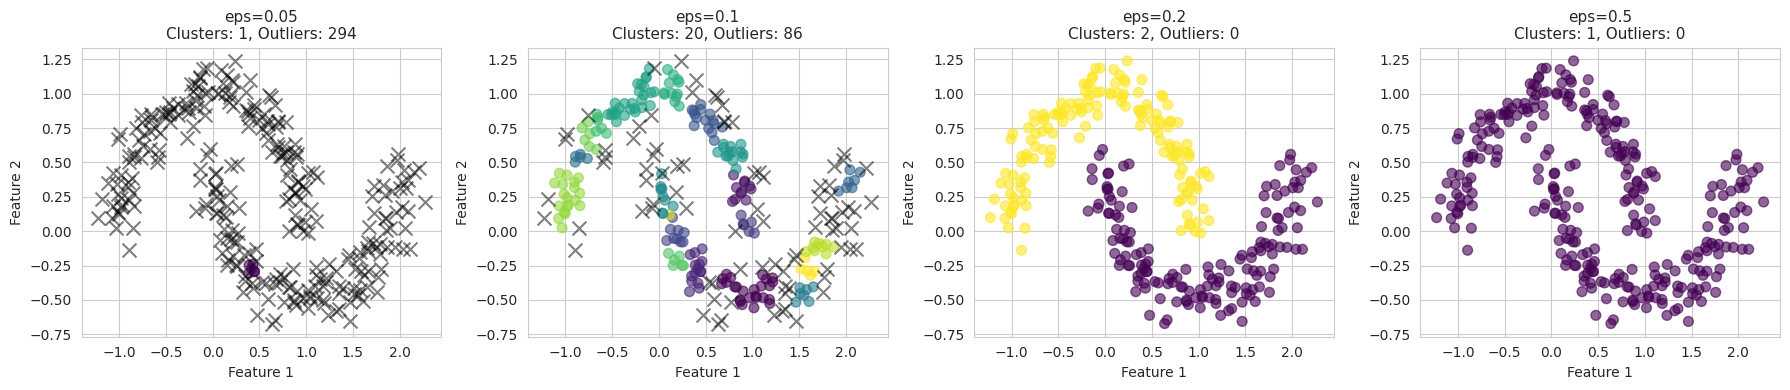

In [22]:
# Experiment with different eps values
eps_values = [0.05, 0.1, 0.2, 0.5]
fig, axes = plt.subplots(1, len(eps_values), figsize=(18, 4))

for idx, eps_val in enumerate(eps_values):
    dbscan_temp = DBSCAN(eps=eps_val, min_samples=5)
    labels_temp = dbscan_temp.fit_predict(X_moons)
    
    n_clusters_temp = len(set(labels_temp)) - (1 if -1 in labels_temp else 0)
    n_outliers_temp = np.sum(labels_temp == -1)
    
    # Plot
    mask_clustered = labels_temp != -1
    if np.any(mask_clustered):
        axes[idx].scatter(X_moons[mask_clustered, 0], X_moons[mask_clustered, 1],
                         c=labels_temp[mask_clustered], cmap='viridis', alpha=0.6, s=50)
    if n_outliers_temp > 0:
        mask_outliers = labels_temp == -1
        axes[idx].scatter(X_moons[mask_outliers, 0], X_moons[mask_outliers, 1],
                         c='black', marker='x', s=100, alpha=0.5)
    
    axes[idx].set_title(f'eps={eps_val}\nClusters: {n_clusters_temp}, Outliers: {n_outliers_temp}', fontsize=11)
    axes[idx].set_xlabel('Feature 1')
    axes[idx].set_ylabel('Feature 2')

plt.tight_layout()
plt.show()

**Observation**: eps controls the neighborhood size
- Too small (0.05): Everything becomes noise
- Too large (0.5): All points merge into one cluster

### K-Means vs DBSCAN: When to Use Which?

| Feature | K-Means | DBSCAN |
|---------|---------|--------|
| **Cluster shape** | Spherical only | Any shape |
| **Number of clusters** | Must specify K | Automatic |
| **Handles outliers** | No (assigns all points) | Yes (labels as -1) |
| **Cluster sizes** | Similar sizes work best | Can vary |
| **Speed** | Very fast O(n×K×d×i) | Slower O(n²) or O(n log n) |
| **Parameters** | K (# clusters) | eps, min_samples |

**Use K-Means when**:
- You know (or can estimate) the number of clusters
- Clusters are roughly spherical and similar in size
- Speed is important (K-Means is fast!)

**Use DBSCAN when**:
- Clusters have irregular shapes
- You want to identify outliers
- You don't know the number of clusters

---

## Key takeaways

1. **Clustering is unsupervised**: We find patterns without labels, making evaluation inherently challenging
2. **K-Means is simple but limited**: Fast and intuitive, but assumes spherical clusters and requires specifying K
3. **Choosing K matters**: Use the elbow method on an appropriate metric (like inertia), but remember this is heuristic
4. **Curse of dimensionality affects clustering**: With many features, distances become less meaningful -> consider PCA first
5. **DBSCAN handles complexity**: Discovers arbitrary shapes and identifies outliers, but requires tuning eps and min_samples
6. **No universal best algorithm**: Choose based on your data structure, domain knowledge, and what you want to discover
7. **Preprocessing is crucial**: Always scale features before clustering (and before PCA)